In [1]:
import gym
from gym import spaces
import numpy as np
import random
import logging
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import datetime
import pandas as pd
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorflow.keras.layers import Dense, Input, Concatenate, LeakyReLU, BatchNormalization, Lambda, Add, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.summary import create_file_writer

from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

print("Tensorflow version: ", tf.__version__)
print("Keras version: ", tf.keras.__version__)
print("Gym version: ", gym.__version__)
print("Numpy version: ", np.__version__)
print("Torch version: ", torch.__version__)

import sys
print("Python version: ", sys.version)

Tensorflow version:  2.12.0
Keras version:  2.12.0
Gym version:  0.26.2
Numpy version:  1.23.5
Torch version:  2.0.1+cpu
Python version:  3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]


In [2]:
def process_actions(action, input_requests):
    action_sum = np.sum(action)
    if action_sum == 0:
        action_sum += 1e-8
    action /= action_sum

    # Aggiungi queste righe per controllare se action[0] o input_requests sono NaN
    if np.isnan(action[0]) or np.isnan(input_requests):
        print(f"Error: action[0] is {action[0]} and input_requests is {input_requests}")
        return None, None, None

    action_result = action[0] * input_requests

    # Controlla se action_result è NaN
    if np.isnan(action_result):
        print(f"Error: action_result is {action_result}")
        return None, None, None

    local = int(action[0] * input_requests)
    local_fraction = (action[0] * input_requests) - local
    forwarded = int(action[1] * input_requests)
    forwarded_fraction = (action[1] * input_requests) - forwarded
    rejected = int(action[2] * input_requests)
    rejected_fraction = (action[2] * input_requests) - rejected
    total_actions = local + forwarded + rejected

    if total_actions < input_requests:
        fractions = [local_fraction, forwarded_fraction, rejected_fraction]
        actions = [local, forwarded, rejected]
        max_fraction_index = np.argmax(fractions)
        actions[max_fraction_index] += input_requests - total_actions
        local, forwarded, rejected = actions

    return local, forwarded, rejected

In [3]:
def calculate_reward1(local, forwarded, rejected, LOCAL_queue_factor, FORWARD_queue_factor, queue_threshold):
    queue_threshold = 0.1
    
    if LOCAL_queue_factor <= queue_threshold and FORWARD_queue_factor <= queue_threshold:
        reward_reject = rejected * (1 - LOCAL_queue_factor) * (1 - FORWARD_queue_factor)
    else:
        reward_reject = -2 * rejected * LOCAL_queue_factor

    reward_local = 2 * local * LOCAL_queue_factor * (1.0001 - FORWARD_queue_factor)
    reward_forward = forwarded * (1.0001 - LOCAL_queue_factor) * FORWARD_queue_factor
    
    reward = reward_local + reward_forward + reward_reject
    return reward

In [4]:
class TrafficManagementEnv(gym.Env):
    def __init__(self, local_CPU_capacity=50, local_queue_capacity = 100, local_queue_length = 0, forward_CPU_capacity = 50 , forward_queue_capacity = 100, forward_queue_length =0, average_requests = 100, amplitude_requests = 50, period=25):
        super().__init__()

        self.action_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float64)
        self.observation_space = spaces.Box(low=np.array([50, -100, -100, 0, 0]), high=np.array([150, 50, 50, 100, 100]), dtype=np.float64)

        self.max_local_CPU_capacity = local_CPU_capacity
        self.local_CPU_capacity = self.max_local_CPU_capacity
        self.max_local_queue_capacity = local_queue_capacity
        self.local_queue_capacity = self.max_local_queue_capacity
        
        self.max_forward_CPU_capacity = forward_CPU_capacity
        self.forward_CPU_capacity = self.max_forward_CPU_capacity
        self.max_forward_queue_capacity = forward_queue_capacity
        self.forward_queue_capacity = self.max_forward_queue_capacity

        self.average_requests = average_requests
        self.amplitude_requests = amplitude_requests
        self.period = period
        self.t = 0

        self.local_queue_length = local_queue_length
        self.forwardl_queue_length = forward_queue_length
        self.input_requests = self.calculate_requests()
        

    def calculate_requests(self):
        return int(self.average_requests + self.amplitude_requests * math.sin(2*math.pi*self.t/self.period))
    
    def reset(self):

        self.local_CPU_capacity = self.max_local_CPU_capacity
        self.local_queue_capacity = self.max_local_queue_capacity
        self.local_queue_length = 0

        self.forward_CPU_capacity = self.max_forward_CPU_capacity
        self.forward_queue_capacity = self.max_forward_queue_capacity
        self.forward_queue_length = 0
        self.t = 0

        return np.array([self.input_requests, self.local_CPU_capacity, self.forward_CPU_capacity, self.local_queue_capacity, self.forward_queue_capacity],  dtype=np.float64)

    def step(self, action):
        print(f"INPUT: {self.input_requests}")
        print(f"CPU Capacity: {self.local_CPU_capacity}")
        print(f"Lunghezza Coda Locale: {self.local_queue_length}")

        self.local, self.forwarded, self.rejected = process_actions(action, self.input_requests)

        print(f"LOCAL: {self.local}")
        print(f"FORWARDED: {self.forwarded}")
        print(f"REJECTED: {self.rejected}")

        self.LOCAL_queue_factor = self.local_queue_capacity / self.max_local_queue_capacity
        self.FORWARD_queue_factor = self.forward_queue_capacity / self.max_forward_queue_capacity

        reward = calculate_reward1(self.local, self.forwarded, self.rejected, self.LOCAL_queue_factor, self.FORWARD_queue_factor, 0.1)

        print(f"REWARD: {reward}")

        self.local_queue_length = max(0, self.local - self.local_CPU_capacity)
        self.local_CPU_capacity = max(-100,self.max_local_CPU_capacity - self.local_queue_length)
        self.local_queue_capacity = max(0,self.max_local_queue_capacity - self.local_queue_length)
        
        self.forward_queue_length = max(0, self.forwarded - self.forward_CPU_capacity)
        self.forward_CPU_capacity = max(-100,self.max_forward_CPU_capacity - self.forward_queue_length)
        self.forward_queue_capacity = max(0,self.max_forward_queue_capacity - self.forward_queue_length)
        
        done = self.local_queue_capacity <= 0 or self.forward_queue_capacity <= 0

        info = {
            'requests_handled_locally': self.local,
            'requests_forwarded': self.forwarded,
            'requests_rejected': self.rejected,
        }

        self.t += 1
        self.input_requests = self.calculate_requests()

        state = np.array([self.input_requests, self.local_CPU_capacity, self.forward_CPU_capacity, self.local_queue_capacity, self.forward_queue_capacity],  dtype=np.float64)

        return state, reward, done, info

In [5]:
class SAC:
    def __init__(self, env, lr_actor=0.0001, lr_critic=0.001, gamma=0.5, tau=0.005, alpha=0.3):
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha

        self.actor = self.build_actor()
        self.critic = self.build_critic()
        self.target_critic = self.build_critic()
        self.target_critic.set_weights(self.critic.get_weights())

        self.actor_optimizer = Adam(learning_rate=lr_actor)
        self.critic_optimizer = Adam(learning_rate=lr_critic)

    def build_actor(self):
        inputs = Input(shape=self.env.observation_space.shape)
        x = Dense(128, activation='tanh')(inputs)
        x = Dense(128, activation='tanh')(x)
        alphas = Dense(self.env.action_space.shape[0], activation='sigmoid')(x)  # alphas are the parameters of the Dirichlet distribution
        return Model(inputs, alphas)

    def build_critic(self):
        state_inputs = Input(shape=self.env.observation_space.shape)
        action_inputs = Input(shape=self.env.action_space.shape)
        x = Concatenate()([state_inputs, action_inputs])
        x = Dense(128, activation='tanh')(x)
        x = Dense(128, activation='tanh')(x)
        q_values = Dense(self.env.action_space.shape[0])(x)
        return Model([state_inputs, action_inputs], q_values)

    def act(self, state):
        state = np.expand_dims(state, axis=0)
        alphas = self.actor(state).numpy()[0]
        action = np.random.dirichlet(alphas)  # sample action from Dirichlet distribution
        return action

    def train(self, replay_buffer, batch_size=64):
        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

        with tf.GradientTape() as tape:
            # critic training
            next_actions = self.actor(next_states)
            next_q_values = self.target_critic([next_states, next_actions])
            #target_q_values = rewards + (1 - dones) * self.gamma * (next_q_values - self.alpha * np.log(next_actions))
            target_q_values = rewards[:, None] + (1 - dones[:, None]) * self.gamma * (next_q_values - self.alpha * np.log(next_actions))
            q_values = self.critic([states, actions])
            critic_loss = tf.reduce_mean((q_values - target_q_values) ** 2)
        critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

        with tf.GradientTape() as tape:
            # actor training
            actions = self.actor(states)
            q_values = self.critic([states, actions])
            actor_loss = tf.reduce_mean(self.alpha * actions - q_values)
        actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))

        self.soft_update(self.target_critic, self.critic)
        return actor_loss, critic_loss, self.alpha

    def soft_update(self, target_model, model):
        for target_var, var in zip(target_model.trainable_variables, model.trainable_variables):
            target_var.assign((1 - self.tau) * target_var + self.tau * var)

In [6]:
class ReplayBuffer:
    def __init__(self, buffer_size=200000):
        self.buffer = []
        self.buffer_size = buffer_size

    def store(self, state, action, reward, next_state, done):
        if len(self.buffer) >= self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append([state, action, reward, next_state, done])
        print(f"Buffer length: {len(self.buffer)}")

    def sample(self, batch_size):
        samples = np.array(random.sample(self.buffer, batch_size))
        return (
            np.stack(samples[:, 0]),
            np.stack(samples[:, 1]),
            samples[:, 2].astype(float),
            np.stack(samples[:, 3]),
            samples[:, 4].astype(float),
        )

In [7]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

window_size = 50

In [8]:
def train_sac_agent(env, agent, num_episodes=2000, max_steps_per_episode=50, buffer_size=200000, batch_size=64, warm_up=1024):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/sac/' + current_time
    summary_writer = tf.summary.create_file_writer(train_log_dir)

    replay_buffer = ReplayBuffer(buffer_size)
    steps = 0
    total_reward = []
    steps_reward = []
    actor_losses = []
    critic_losses = []
    #alphas = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        actor_loss = 0
        critic_loss = 0
        #alpha = 0

        for step in range(max_steps_per_episode):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.store(state, action, reward, next_state, done)

            if steps > warm_up:
                actor_loss_step, critic_loss_step, alpha_step = agent.train(replay_buffer, batch_size)
                actor_loss += actor_loss_step
                critic_loss += critic_loss_step
                #alpha += alpha_step

                with summary_writer.as_default():  # log losses and reward
                    tf.summary.scalar('actor_loss', actor_loss, step=steps)
                    tf.summary.scalar('critic_loss', critic_loss, step=steps)
                    tf.summary.scalar('episode_reward', episode_reward, step=steps)
                    #tf.summary.scalar('alpha', alpha, step=steps)

            state = next_state
            episode_reward += reward
            steps_reward.append(reward)
            steps += 1

            if done:
                break

        print(f"Episode {episode + 1}, Reward: {episode_reward}, Steps: {steps}")
        logging.info(f"Episode {episode + 1}, Reward: {episode_reward}, Steps: {steps}")
        
        #agent.save_weights("C:/Users/giaco/Desktop/tesi-git/Pesi reti")

        actor_losses.append(actor_loss / max_steps_per_episode if step > 0 else actor_loss)
        critic_losses.append(critic_loss / max_steps_per_episode if step > 0 else critic_loss)
        #alphas.append(alpha / max_steps_per_episode if step > 0 else alpha)
        total_reward.append(episode_reward)

    smoothed_rewards_steps = moving_average(steps_reward, window_size)
    smoothed_total_reward = moving_average(total_reward, window_size)
    smoothed_actor_losses = moving_average(actor_losses, window_size)
    smoothed_critic_losses = moving_average(critic_losses, window_size)

    steps_metrics = pd.DataFrame({
        'Rewards Steps': steps_reward
    })
    steps_metrics.to_csv('steps_metrics.csv')
    
    metrics = pd.DataFrame({
        'Rewards Episodi': total_reward,
        'actor_losses': actor_losses,
        'critic_losses': critic_losses,
        #'alphas': alphas
    })

    metrics.to_csv('training_metrics_SAC.csv')

    plt.plot(smoothed_rewards_steps)
    plt.xlabel('Episode')
    plt.ylabel('Reward di ogni step')
    plt.rcParams["figure.figsize"] = (20,10)
    plt.show()

    plt.plot(smoothed_total_reward)
    plt.xlabel('Episode')
    plt.ylabel('Reward di ogni episodio')
    plt.rcParams["figure.figsize"] = (20,10)
    plt.show()

    plt.plot(smoothed_actor_losses)
    plt.xlabel('Training Steps')
    plt.ylabel('ActorLoss')
    plt.legend()
    plt.rcParams["figure.figsize"] = (20,10)
    plt.show()

    plt.plot(smoothed_critic_losses)
    plt.xlabel('Training Steps')
    plt.ylabel('CriticLoss')
    plt.legend()
    plt.rcParams["figure.figsize"] = (20,10)
    plt.show()


c:\Users\giaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


INPUT: 100
CPU Capacity: 50
Lunghezza Coda Locale: 0
LOCAL: 5
FORWARDED: 94
REJECTED: 1
REWARD: -1.9896000000000011
Buffer length: 1
INPUT: 112
CPU Capacity: 50
Lunghezza Coda Locale: 0
LOCAL: 18
FORWARDED: 5
REJECTED: 89
REWARD: -162.15612
Buffer length: 2
INPUT: 124
CPU Capacity: 50
Lunghezza Coda Locale: 0
LOCAL: 0
FORWARDED: 0
REJECTED: 124
REWARD: -248.0
Buffer length: 3
INPUT: 134
CPU Capacity: 50
Lunghezza Coda Locale: 0
LOCAL: 97
FORWARDED: 3
REJECTED: 34
REWARD: -67.9803
Buffer length: 4
INPUT: 142
CPU Capacity: 3
Lunghezza Coda Locale: 47
LOCAL: 6
FORWARDED: 68
REJECTED: 68
REWARD: -40.112564
Buffer length: 5
INPUT: 147
CPU Capacity: 47
Lunghezza Coda Locale: 3
LOCAL: 19
FORWARDED: 106
REJECTED: 22
REWARD: -33.425222
Buffer length: 6
INPUT: 149
CPU Capacity: 50
Lunghezza Coda Locale: 0
LOCAL: 0
FORWARDED: 111
REJECTED: 38
REWARD: -75.997114
Buffer length: 7
Episode 1, Reward: -629.6609199999999, Steps: 7
INPUT: 149
CPU Capacity: 50
Lunghezza Coda Locale: 0
LOCAL: 77
FORWARDED

C:\Users\giaco\AppData\Local\Temp\ipykernel_5696\1947288514.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = np.array(random.sample(self.buffer, batch_size))


INPUT: 142
CPU Capacity: 50
Lunghezza Coda Locale: 0
LOCAL: 23
FORWARDED: 12
REJECTED: 107
REWARD: -196.974644
Buffer length: 1030
INPUT: 147
CPU Capacity: 50
Lunghezza Coda Locale: 0
LOCAL: 5
FORWARDED: 70
REJECTED: 72
REWARD: -143.992
Buffer length: 1031
INPUT: 149
CPU Capacity: 50
Lunghezza Coda Locale: 0
LOCAL: 2
FORWARDED: 34
REJECTED: 113
REWARD: -225.19688
Buffer length: 1032
INPUT: 149
CPU Capacity: 50
Lunghezza Coda Locale: 0
LOCAL: 76
FORWARDED: 6
REJECTED: 67
REWARD: -127.904224
Buffer length: 1033
INPUT: 145
CPU Capacity: 24
Lunghezza Coda Locale: 26
LOCAL: 9
FORWARDED: 0
REJECTED: 136
REWARD: -201.278668
Buffer length: 1034
INPUT: 138
CPU Capacity: 50
Lunghezza Coda Locale: 0
LOCAL: 0
FORWARDED: 59
REJECTED: 79
REWARD: -157.9941
Buffer length: 1035
INPUT: 129
CPU Capacity: 50
Lunghezza Coda Locale: 0
LOCAL: 100
FORWARDED: 0
REJECTED: 29
REWARD: -39.980000000000004
Buffer length: 1036
INPUT: 118
CPU Capacity: 0
Lunghezza Coda Locale: 50
LOCAL: 102
FORWARDED: 2
REJECTED: 14


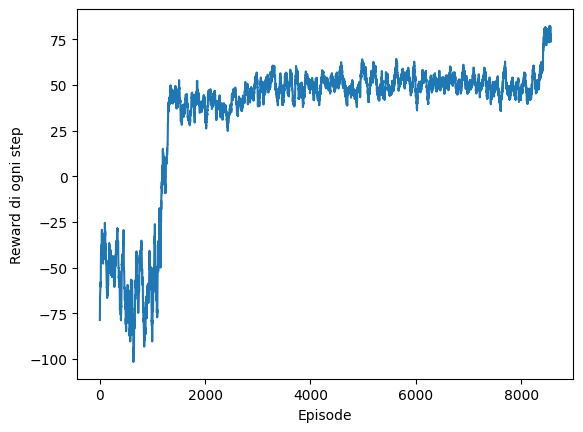

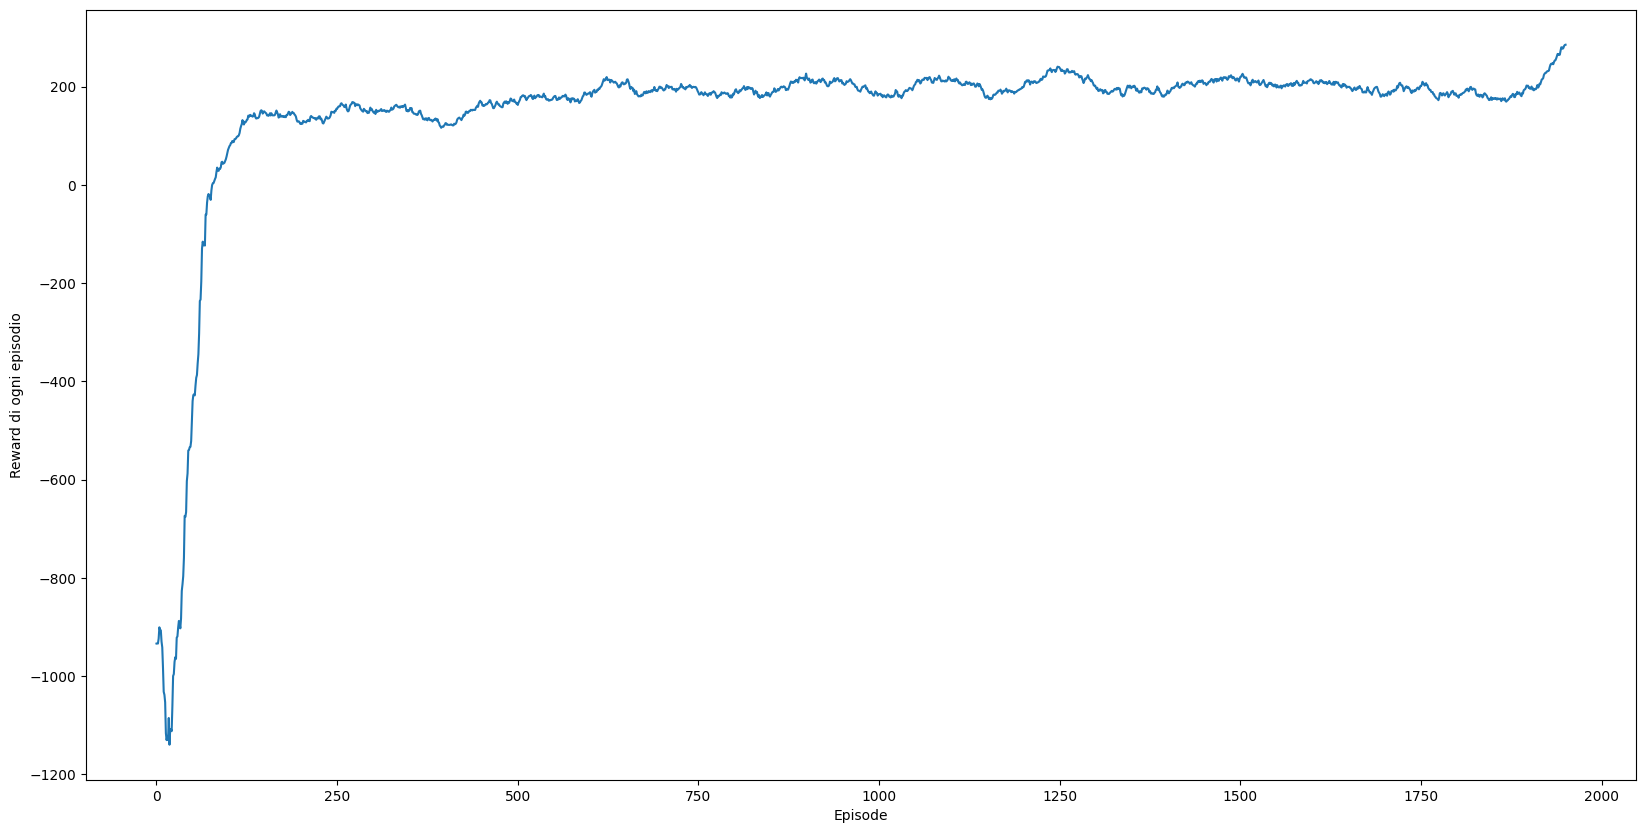

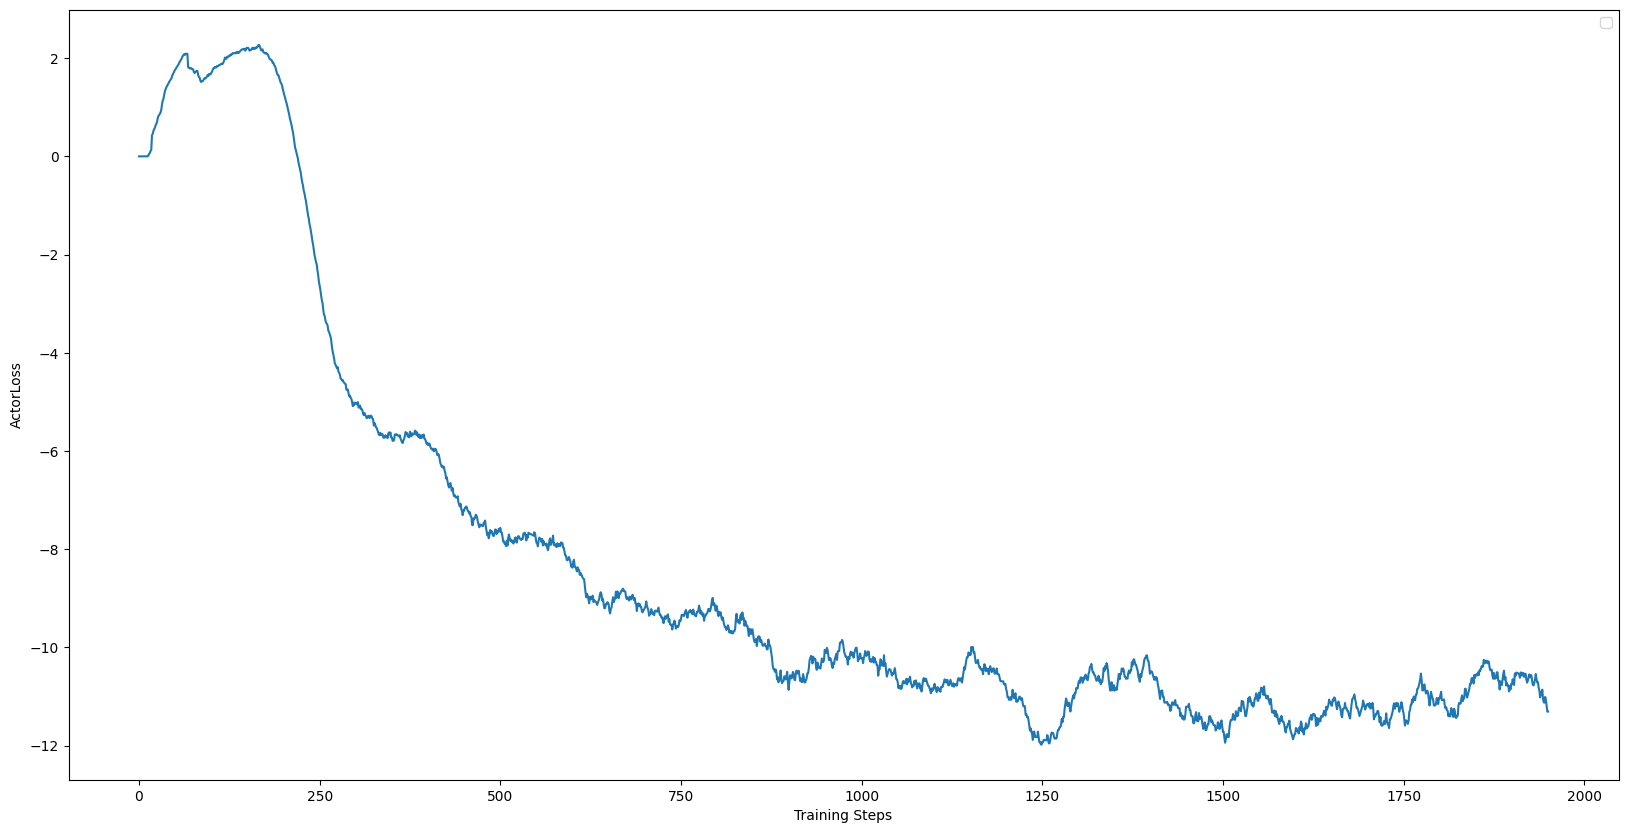

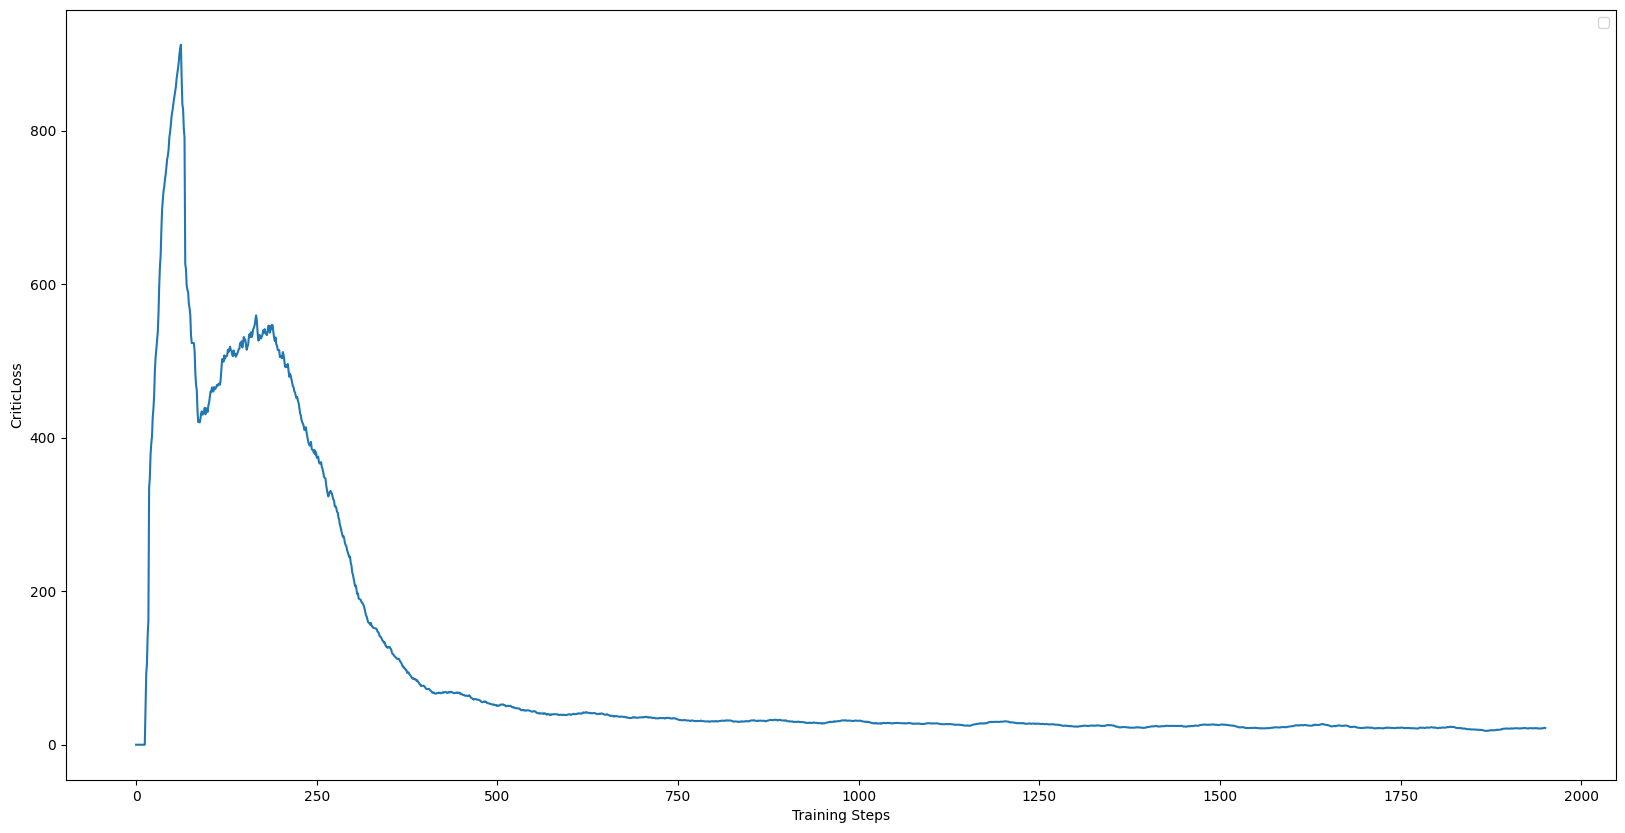

In [9]:
if __name__ == "__main__":
    env = TrafficManagementEnv()
    agent = SAC(env)
    train_sac_agent(env, agent)